In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from datetime import datetime, timedelta
from metpy.units import units
from metpy.calc import wind_components

In [2]:
def datetime_range(start, end, delta):
    current = start
    while current <= end:
        yield current
        current += delta

def csv_list(year, month, date):
    dts = [f'{dt.hour}-{dt.minute}.csv' for dt in 
           datetime_range(datetime(year, month, date, 0), datetime(year, month, date, 23, 59), timedelta(minutes=10))]
    return dts

def calc_u_v(df, ob_point):
    wind_dir = df['WD1']
    wind_speed = df['WS1']
    wind_u_v = wind_components(wind_speed * units('m/s'), wind_dir * units.deg)
    return [ob_point, round(wind_u_v[0].magnitude, 5), round(wind_u_v[1].magnitude, 5)] # (index, u wind, v wind) u: X (East-West) v: Y(North-South)

csv_files = csv_list(2020, 1, 1)

over5_rain_csvnames = {}
rain = []
root_path = '../../../data/one_day_data/2019/'
monthes = [10, 11]
cols = ['hour-rain']
for month in monthes:
    if month < 10:
        month = '0'+str(month)
    else:
        month = str(month)
    for date in os.listdir(root_path + month):
        for i in range(0, 133, 12):
            max_rain = 0
            for csv_file in csv_files[i:i+12]:
                one_df = pd.read_csv(root_path + f'{month}/{date}/{csv_file}', index_col=0) # index: observation name
                one_df.index.names = ['ob_point']
                wind_df = pd.DataFrame( [calc_u_v(one_df.loc[i, :], i) for i in one_df.index], columns=['ob_point', 'u_wind', 'v_wind'])
                wind_df = wind_df.set_index('ob_point')
                one_df = one_df.merge(wind_df, how='left', on='ob_point')
                if one_df['hour-rain'].max() > max_rain:
                    max_rain = one_df['hour-rain'].max()
            if max_rain > 5:
                if not date in over5_rain_csvnames:
                    over5_rain_csvnames[date] = []
                over5_rain_csvnames[date].append(csv_files[i:i+12])
                
            rain.append(max_rain)
rain_df = pd.DataFrame({'rain':rain })

In [6]:
valid_data_list = []
cols = ['date', 'start', 'end']
count = 0
for key in over5_rain_csvnames.keys():
    files = over5_rain_csvnames[key]
    for file in files:
        start = file[0]
        end = file[-1]
        valid_data_list.append([key, start, end])
df = pd.DataFrame(valid_data_list, columns=cols)
df.head()
df.to_csv('valid_data_list.csv')

In [15]:
df = pd.read_csv('valid_data_list.csv')
dates = df['date'].unique()
for date in dates:
    files = df.loc[df['date'] == date]
    for i in files.index:
        start, end = files.loc[i, 'start'], files.loc[i, 'end']
        print(start, end)
    break

2-0.csv 3-50.csv
4-0.csv 5-50.csv
6-0.csv 7-50.csv
12-0.csv 13-50.csv
14-0.csv 15-50.csv


2.8968253968253967 % rain dataset in all dataset


,rain
count,732.000000
mean,2.373634
std,7.749503
min,0.000000
25%,0.000000
50%,0.000000
75%,0.500000
max,63.500000


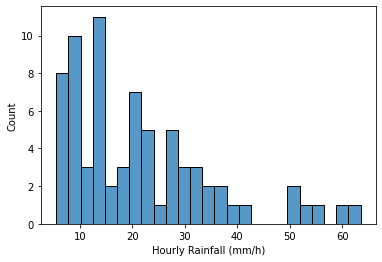

In [5]:
rain_df_over1 = rain_df.loc[rain_df['rain'] > 5]
fig, ax = plt.subplots()
sns.histplot(rain_df_over1, bins=25, ax=ax)
ax.set_xlabel('Hourly Rainfall (mm/h)')
ax.get_legend().remove()
plt.savefig('rain_histplot.png')
print((len(rain_df_over1)/(30*12*7))*100, '% rain dataset in all dataset')
rain_df.describe()

In [7]:
data = {} 
for date in [*over5_rain_csvnames]:
    if not date in data:
        data[date] = []
    for csv_names in over5_rain_csvnames[date]:
        df = pd.DataFrame()
        month = date.split('-')[1]
        max_rain = 0
        for csv_name in csv_names:
            one_df = pd.read_csv(root_path + f'{month}/{date}/{csv_name}', index_col=0)
            if one_df['hour-rain'].max() > max_rain:
                max_rain = one_df['hour-rain'].max()
            for ob_point in one_df.index:
                ob = ob_point.split('_')[0]
                for col in one_df.columns:
                    df.loc[csv_name, f'{col}-{ob}'] = one_df.loc[ob_point, col]
        data[date].append(df)
        if max_rain > 50:
            print(date, max_rain)

2019-10-04 51.5
2019-10-04 63.5
2019-10-12 56.0
2019-10-12 59.5
2019-10-02 52.5


In [25]:
# Calculate RMSE
csv_files = csv_list(2020,1,1)
monthes = ['10', '11']
prediction_root = '../../../data/prediction_image/oneByone_model/60min_ruv_model_selectedData_optuned/2019/'
label_root = '../../../data/rain_image/2019/'

for month in monthes:
    for date in os.listdir(label_root + month):
        rmse_df = pd.DataFrame()
        for csv_file in csv_files[6:]:
            label_data = pd.read_csv(label_root + month + f'/{date}/{csv_file}', index_col=0)
            pred_data = pd.read_csv(prediction_root + month + f'/{date}/{csv_file}', index_col=0)
            rmse = ((label_data.values - pred_data.values) ** 2).mean() ** .5
            rmse_df.loc[csv_file, 'RMSE'] = rmse
        rmse_df.to_csv(prediction_root + month + f'/RMSE/{date}.csv')

In [19]:
label_data.values.shape

(50, 50)